**Description:** 

Training of a generative adversarial network on the fashion MNIST dataset.

**References:**

https://github.com/yunjey/pytorch-tutorial  
https://github.com/mickypaganini/GAN_tutorial

## 1. Load Modules

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import glob
import matplotlib.animation as animation
import matplotlib.image as mpimg
from sklearn.cluster import MiniBatchKMeans, DBSCAN
import IPython
%matplotlib inline

torch.__version__

'0.3.1.post2'

## 2. Analyze Data

In [2]:
# Composes several transforms together.
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x : 2 * x - 1) # normalize to be in [-1, 1]
            ])

# Load data.
dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

In [3]:
# check that there exist 10 different classes
np.unique(dataset.train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

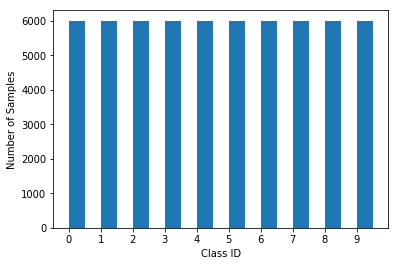

In [4]:
# check class proportions
plt.hist(dataset.train_labels,
         bins=np.linspace(0, 9.5, 20))

_ = plt.xticks(range(10))
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.show()

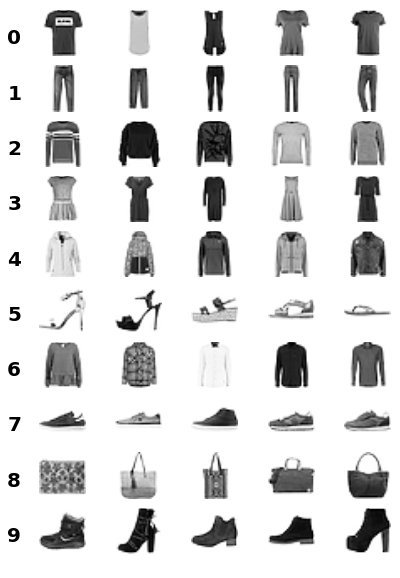

In [5]:
# plot 5 examples from each class
n_images = 5

f, axarr = plt.subplots(len(np.unique(dataset.train_labels)), n_images, figsize=(10, 10))
f.subplots_adjust(wspace=-0.7)

for n_class in np.unique(dataset.train_labels):
    # annotate axis with class
    axarr[n_class, 0].text(-20, 20, str(n_class), size=20, weight='bold')
    # plot 5 images
    for n_img, image in enumerate(dataset.train_data.numpy()[dataset.train_labels.numpy() == n_class][:n_images]):
        axarr[n_class, n_img].imshow(image, interpolation='bilinear', cmap='Greys')
        axarr[n_class, n_img].axis('off')
        

## 3. GAN Model and Training

In [8]:
## Model design

BATCH_SIZE = 100
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=3)

n_batches = int(np.ceil(len(dataset)/ BATCH_SIZE))  

# Discriminator
D = nn.Sequential(
    nn.Linear(28 * 28, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# Generator 
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 28 * 28),
    nn.Tanh()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    D.cuda()
    G.cuda()
    
# Define loss function and optimizer
criterion = nn.BCELoss()  
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def denorm(x):
    ''' convert back from [-1, 1] to [0, 1] '''
    out = (x + 1) / 2
    return out  

In [13]:
## Training

N_EPOCHS = 2  

try: 
    for epoch in range(N_EPOCHS):
        for batch_number, (images, _) in enumerate(data_loader): 

            # Reshape images from (batch_size, 28, 28) to (batch_size, 28*28)  
            batch_size = images.shape[0]
            images = to_var(images.view(batch_size, -1))

            # Create targets for the discriminator network D
            real_labels = to_var(torch.ones(batch_size, 1)) 
            fake_labels = to_var(torch.zeros(batch_size, 1))
            
            # Compute discriminator loss with respect to real labels
            outputs = D(images) # Evaluate the discriminator on the real input images
            real_score = outputs
            d_loss_real = criterion(outputs, real_labels) 
            
            # Compute discriminator loss with respect to fake labels
            z = to_var(torch.randn(batch_size, 64)) # the latent space is 64 dimensional
            fake_images = G(z) # synthetic images from generator
            outputs = D(fake_images) # Evaluate the discriminator on the fake images
            fake_score = outputs
            d_loss_fake = criterion(outputs, fake_labels) # Discriminator loss with respect to fake labels

            # Backprop + Optimize the discriminator
            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Compute cross-entropy loss with with "real" as target
            z = to_var(torch.randn(batch_size, 64))
            fake_images = G(z)
            outputs = D(fake_images)
            g_loss = criterion(outputs, real_labels)

            # Backprop + Optimize the generator
            D.zero_grad()  
            G.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # Print status.
            if (batch_number + 1) % 300 == 0:
                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                      'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                      %(epoch,
                        N_EPOCHS,
                        batch_number + 1,
                        n_batches,
                        d_loss.data[0],
                        g_loss.data[0],
                        real_score.data.mean(),
                        fake_score.data.mean())
                )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/real_images.png')

        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/fake_images-%0.3d.png' %(epoch + 1))
        
        # Save the trained parameters 
        torch.save(G.state_dict(), './weights/generator-%0.3d.pkl' %(epoch + 1))
        torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print('Training ended early.')

Epoch [0/2], Step[300/600], d_loss: 0.3668, g_loss: 3.2256, Mean D(x): 0.90, Mean D(G(z)): 0.17
Epoch [0/2], Step[600/600], d_loss: 0.0894, g_loss: 4.3155, Mean D(x): 0.97, Mean D(G(z)): 0.05
Epoch [1/2], Step[300/600], d_loss: 0.3291, g_loss: 3.3959, Mean D(x): 0.88, Mean D(G(z)): 0.07
Epoch [1/2], Step[600/600], d_loss: 0.2565, g_loss: 4.1774, Mean D(x): 0.91, Mean D(G(z)): 0.04


<IPython.core.display.Javascript object>


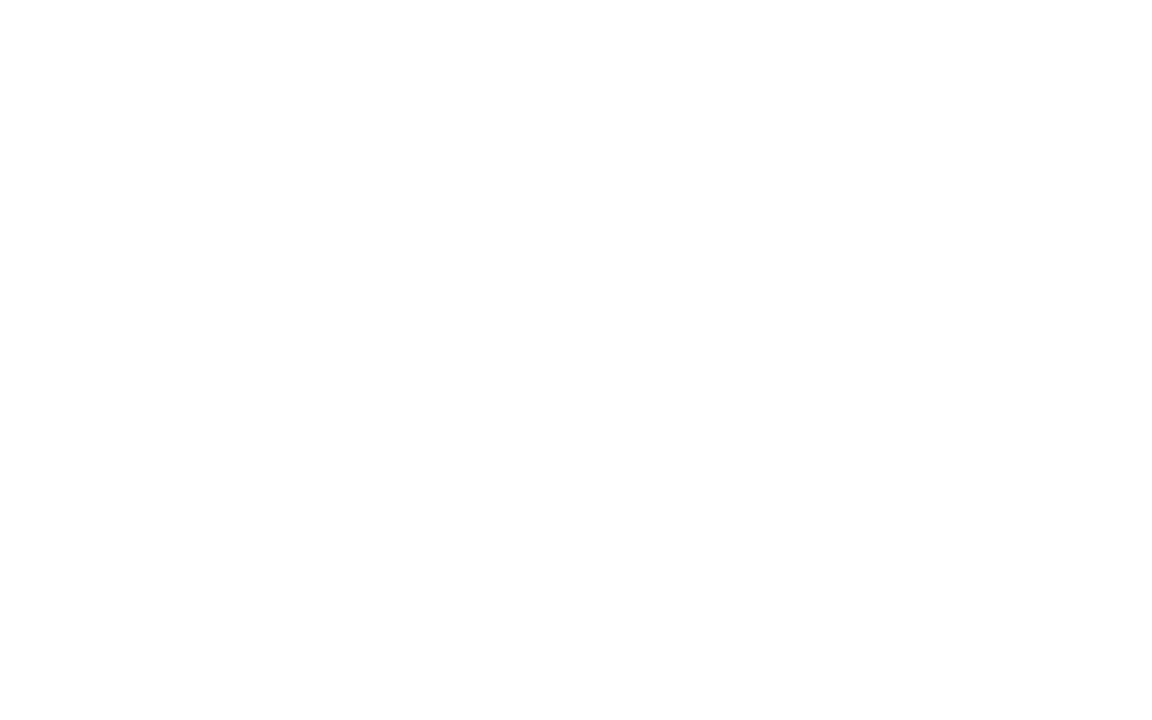

ValueError: Invalid file object: <_io.BufferedReader name=80>

<IPython.core.display.Javascript object>


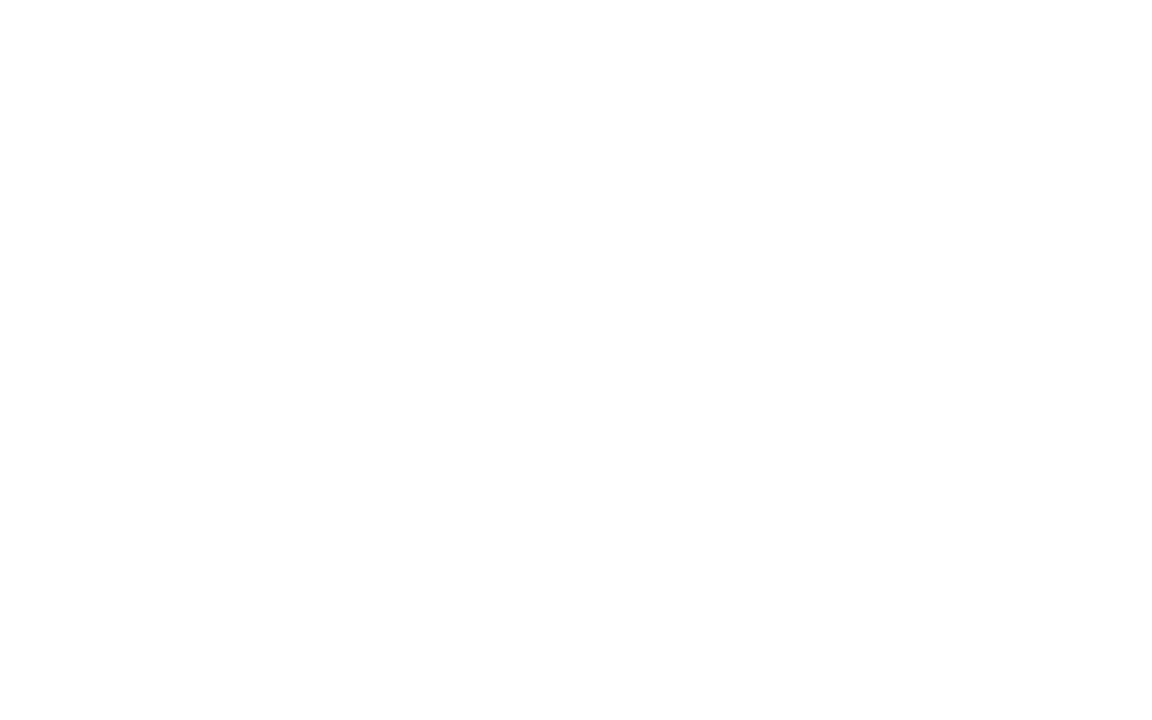

Traceback (most recent call last):
  File "/Users/raoul/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/Users/raoul/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/Users/raoul/anaconda/lib/python3.6/site-packages/matplotlib/animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [33]:
# load final weights
G.load_state_dict(torch.load('./weights/generator-final.pkl'))
D.load_state_dict(torch.load('./weights/discriminator-final.pkl'))

%matplotlib notebook
fig = plt.figure(figsize=(8, 5))
ims = []
for path in glob.glob('data/fake_images-*.png')[::20]:
    imread = mpimg.imread(path)
    im = plt.imshow(imread, animated=True)
    ims.append([im])
#     print path
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.show()
ani.save('dynamic_images.mp4')

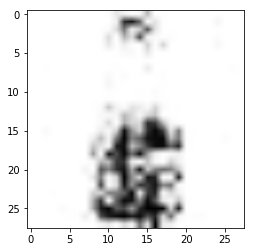

In [18]:
## Create a set of fake images 

%matplotlib inline
z = to_var(torch.randn(60000, 64))
fake_images = G(z).data.numpy().reshape(60000, 28, 28)
plt.imshow(fake_images[1], cmap='Greys', interpolation='bilinear')

Text(0.5,0,'Number of clusters')

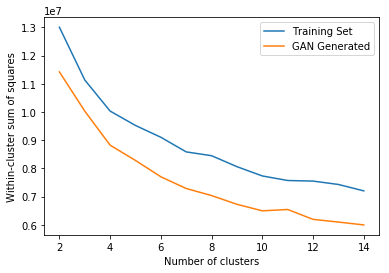

In [19]:
## Apply kmeans on real and fake images

inertia = []
normed_real_images = dataset.train_data.numpy().reshape(len(dataset), -1) / 255. * 2. - 1.
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(normed_real_images)
    inertia.append(model.inertia_)
    
inertia_gan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(fake_images.reshape(60000, -1))
    inertia_gan.append(model.inertia_)
    
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters')

## 4. Wasserstein GAN Model and Training

In [24]:
## Define some functions and the model
 
def add_instance_noise(images, std=0.1):
    '''
    add normal noise to images
    '''
    noise = Variable(std * torch.randn(images.shape))
    return images + noise

def label_flip(x, p=0.05):
    '''
    bit flip with some probability
    Args:
    ----
        x = torch.FloatTensor
        p = float, probability of flip
    Returns:
    --------
        x_new = torch.FloatTensor
    '''
    x_new = x.clone()
    selection = torch.rand(x_new.shape) < prob
    x_new[selection] = (x_new[selection].type(torch.ByteTensor)^1).type(torch.FloatTensor)
    return x_new

def label_smoothe(x, p=0.05, smoothing_param=0.3):
    '''
    label smoothing with some probability
    Args:
    ----
        x = torch.FloatTensor
        p = float, probability of an entry being selected for smoothing
        smoothing_param = float, max amount of variation
    Returns:
    --------
        x_new = torch.FloatTensor
    '''
    x_new = x.clone()
    selection = torch.rand(x_new.shape) < prob
    smoothing = torch.rand(selection.sum()) * smoothing_param
    x_new[selection] = torch.abs(x_new[selection] - smoothing)
    return x_new

# Critic
critic = nn.Sequential(
    nn.Linear(28 * 28, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

# Generator 
generator = nn.Sequential(
    nn.Linear(64, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 28 * 28),
    nn.Tanh()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()
    
# These are the recommended defaults (sauf N_EPOCHS) from the WGAN paper.
LR = 0.00005
N_EPOCHS = 2
N_CRITIC_STEPS = 5
CLAMP = 0.01

critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

In [26]:
## WGAN Training

try: 
    for epoch in range(N_EPOCHS):
        
        crit_steps = 0 # Keep track of what critic step we're on
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 28, 28) to (batch_size, 28*28)
            images = to_var(images.view(batch_size, -1))

            # Train critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum grads with real images (we want the critic to output a high value here)
                err_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (we want the critic to output a low value here)
                err_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize err_real - err_fake
                critic_loss = err_fake - err_real
                critic_loss.backward()
                critic_optimizer.step()
                
                # We increment our counter now that we've seen a critic update
                crit_steps += 1
                
            # Train generator
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            critic_loss.data[0],
                            generator_loss.data[0],
                            err_real.data.mean(),
                            err_fake.data.mean())
                    )

        # Save real images once
        if (epoch + 1) == 1:
            images = images.view(images.size(0), 1, 28, 28) # reshape
            save_image(denorm(images.data), './data/wgan_real_images.png')

        # Save sampled images
        fake_images = fake_images.view(fake_images.size(0), 1, 28, 28) #reshape
        save_image(denorm(fake_images.data), './data/wgan_fake_images-%0.3d.png' %(epoch + 1))

        # Save the trained parameters 
        torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print('Training ended early.')

Epoch [0/2], Step[300/600], d_loss: -0.7526, g_loss: -3.6202, Mean D(x): 4.40, Mean D(G(z)): 3.65
Epoch [0/2], Step[600/600], d_loss: -0.1983, g_loss: -3.9666, Mean D(x): 4.16, Mean D(G(z)): 3.96
Epoch [1/2], Step[300/600], d_loss: -0.2796, g_loss: -1.1045, Mean D(x): 1.40, Mean D(G(z)): 1.12
Epoch [1/2], Step[600/600], d_loss: -1.5964, g_loss: -0.2744, Mean D(x): 1.84, Mean D(G(z)): 0.24


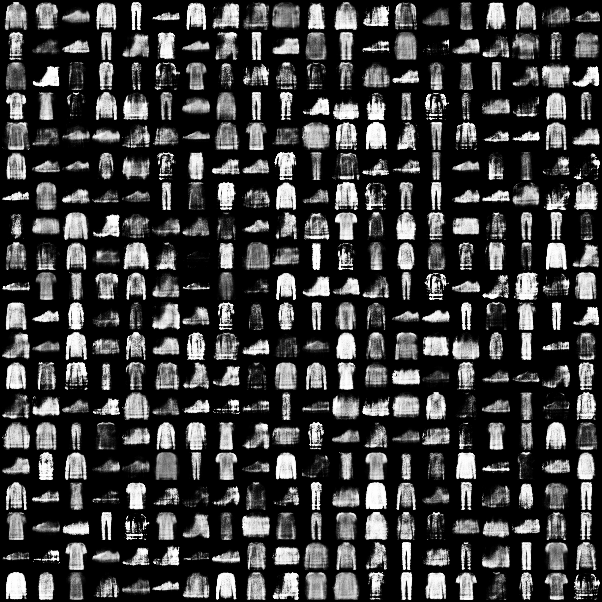

In [31]:
# Load back saved weights (we have these pre-trained)
generator.load_state_dict(torch.load('./weights/wgan_generator-final.pkl'))
critic.load_state_dict(torch.load('./weights/wgan_discriminator-final.pkl'))

NB_SAMPLES = 400
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

save_image(denorm(fake_images.view(fake_images.size(0), 1, 28, 28).data), # reshape
           './data/wgan_fake_images_final.png', nrow=20)

IPython.display.Image('./data/wgan_fake_images_final.png')

Text(0.5,0,'Number of clusters')

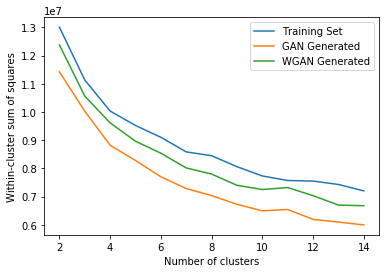

In [32]:
NB_SAMPLES = 60000
z = to_var(torch.randn(NB_SAMPLES, 64))
fake_images = generator(z)

inertia_wgan = []
for n_clusters in range(2, 15):
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(fake_images.data.numpy().reshape(60000, -1))
    inertia_wgan.append(model.inertia_)
    
plt.plot(range(2, 15), inertia, label='Training Set')
plt.plot(range(2, 15), inertia_gan, label='GAN Generated')
plt.plot(range(2, 15), inertia_wgan, label='WGAN Generated')
plt.legend()
plt.ylabel('Within-cluster sum of squares')
plt.xlabel('Number of clusters')